# Score Creation

# Climate Flood Risk Scoring Methodology

## Overview

This methodology calculates flood risk by treating **each Flood-risk level (High, Mid, Low) independently** and then **summing their contributions**, this mean we treat flood with different return period and destructive power as different hazards. 

## Data Structure

### Points 

1. **Geographic Points**: Individual latitude-longitude pairs $(L, l)$
2. **Communes**: Administrative units that can encompass multiple points.

### Points Features

Each point (latitude-longitude pairs) can have multiple records for combinations of:

- **Flood_risk**: Risk classification ∈ {High, Mid, Low}
- **Période**: Time horizon ∈ {H1, H2, H3}
- **ht_min, ht_max**: Water height range (meters)

### Time Horizons

Our **Période** variable has three different occurence : 

- **H1**: 2025–2050 (25 years)
- **H2**: 2051–2070 (20 years)
- **H3**: 2071–2099 (29 years)

### Return Periods

We deduce our **return period** from our **Flood_risk** as defined in the description of our data (see **"COVADIS_standard_DI_v2.1"**)

| Flood Risk | Return Period $T$ | Annual Probability |
|------------|-------------------|--------------------|
| High       | 30 years          | 3.33%              |
| Mid        | 100-300 years     | 0.33%-1%           |
| Low        | 1000 years        | 0.1%               |

## Mathematical Framework

### Core Principle:

The total risk at a location is:

$$\text{Risk}_{\text{total}} = \text{Risk}_{\text{High}} + \text{Risk}_{\text{Mid}} + \text{Risk}_{\text{Low}}$$

Each risk level contributes **independently** to the total expected loss.

### Risk Calculation per Type

For each flood risk type $r \in \{\text{High, Mid, Low}\}$:

#### 1. Time Allocation

The time left before maturity is split across our three different periods, thus the time left in the period $H_i$ before maturity is $n_{L,l,H_i}$:

$$n_{L,l,H1} = \min(n_{L,l}, 25)$$
$$n_{L,l,H2} = \min(n_{L,l} - n_{L,l,H1}, 20)$$
$$n_{L,l,H3} = n_{L,l} - n_{L,l,H1} - n_{L,l,H2}$$

where $n_{L,l}$ is the total years left until maturity.

#### 2. Survival Probability per Period

For flood type $r$ in period $h$ we define our $\text{Survival}$ as:

$$\text{Survival}_{L,l,h,r} = \left(1 - \frac{1}{T_r}\right)^{n_{L,l,h}}$$

**Survival** is the probability of avoiding this specific flood type during period $h$.

#### 3. Multi-Period Survival

The probability of avoiding flood type $r$ across all periods:

$$\text{Survival}_{L,l,r} = \text{Survival}_{L,l,H1,r} \times \text{Survival}_{L,l,H2,r} \times \text{Survival}_{L,l,H3,r}$$

#### 4. Flood Probability

Probability that flood type $r$ occurs at least once:

$$P_{L,l,r} = 1 - \text{Survival}_{L,l,r}$$

#### 5. Damage Factor

For each period $h$ where flood type $r$ data exists, we define our damage as a function of $\text{ht\_min}_{h,r}$ and $\text{ht\_max}_{h,r}$:

$$\text{damage}_{L,l,h,r} = \frac{1}{1 + \exp\left(1 - \frac{\text{ht\_min}_{h,r} + \text{ht\_max}_{h,r}}{2}\right)}$$

We consider here that we lose half of the value of our assets when our mean height reach 1 meter.<br/> 
That's probably overestimated but due to a lack of information on the impact of the height of a flood on the economical loss, we'll use this measure for our damages.

Then we compute a time-weighted average across periods to obtain total $\text{damage\_factor}$ for this risk:

$$\text{damage\_factor}_{L,l,r} = \frac{\sum_{h \in \{H1,H2,H3\}} n_{L,l,h} \cdot \text{damage}_{L,l,h,r}}{n_{L,l}}$$

#### 6. Risk for Type $r$

Then for our risk $r$, our Expected loss (as proportion of asset value) is :

$$\text{Risk}_{L,l,r} = P_{L,l,r} \times \text{damage\_factor}_{L,l,r}$$


### Total Risk

We then sum our partial risks to obtain our total risk

$$\text{Risk}_{L,l} = \sum_{r \in \{\text{High, Mid, Low}\}} \text{Risk}_{L,l,r}$$

**Warning**: theoretically this risk is defined in the interval [0, 3], but in practice stays in [0, 1] since probabilities are small.

**Expected Loss**

In order to obtain a financial loss, we multiply our total risk with our corresponding assets' values at the coordinates $(L,l)$ :

```math
\text{EL}_{L,l} = C_{L,l} \cdot \text{Risk}_{L,l}
```

where $\text{EL}_{L,l}$ is our expected loss (in millions of euros) at coordinates $(L,l)$ and $C_{L,l}$ is the capital (in millions of euros) at coordinates $(L,l)$.

## Assumptions

1. **Independence**: Different flood types are independent events
2. **Linearity**: Damages from different flood types are additive (no compounding)
3. **Stationarity**: Flood probabilities constant within each 20-30 year period
4. **Homogeneity**: All points in commune weighted equally

## Summary

This additive methodology treats each flood risk type as an independent source of expected loss. By calculating probability and damage for High, Mid, and Low risks separately and summing them, we obtain a total risk score that represents the proportion of asset value expected to be lost over the loan lifetime.

# More About our Damage Function

See [legifrance](https://www.legifrance.gouv.fr/loda/id/JORFTEXT000034438478) and [Flood Depth and Building Loss Analysis](https://www.researchgate.net/publication/393679584_Flood_Depth_and_Building_Loss_Analysis_A_Comprehensive_Study_on_Hazard_Impact_Assessment_and_Structural_Vulnerability) for information on the impact of height on the economical loss

> « Les parties de territoires susceptibles d'être affectées par des venues d'eau dangereuses. 
> Sont réputées dangereuses les venues d'eau telles que la **hauteur d'eau** atteint au moins **1 mètre** 
> ou le courant au moins 0,5 mètre par seconde »  
> — *Legifrance*

# Import our Libraries and Classes

In [7]:
import joblib
import pandas as pd
import geopandas as gpd
import torch

from classes.my_classes import FloodScoring, DenseNetClassifier, VisualizeResults, ScoreCreation, Portfolio_Context_Explained

# Import Scaler and Models

In [2]:
scaler = joblib.load("model/ht_scaler.pkl")

# Charger le modèle de hauteur
model_height = DenseNetClassifier(input_dim=17, num_classes_min=4, num_classes_max=7)
model_height.load_state_dict(torch.load('model/model_ht_state.pth'))

# Charger les modèles de classification
models_class = {
    'low': joblib.load("model/RandForestClassifier_low.pkl"),
    'mid': joblib.load("model/RandForestClassifier_mid.pkl"),
    'high': joblib.load("model/RandForestClassifier_high.pkl")
}


# Import Data

In [3]:
scenarios = ['RCP_2.6', 'RCP_4.5', 'RCP_8.5']
data_drias = {}

In [4]:
# Charger les données
for scenario in scenarios:
        url_drias = f"data/Drias_data/{scenario}_with_distance.csv"
        data_drias[scenario] = pd.read_csv(url_drias, sep=';')

data_clay = gpd.read_file("data/Flood/clay_risk_results.csv")
data_clay = data_clay.astype({'longitude': 'Float64', 'latitude': 'Float64'})


# Get Results

In [5]:
for scenario in scenarios:

    # Call our Class
    flood_scorer = FloodScoring(
        scaler=scaler,
        model_height=model_height,
        model_class=models_class,
        data_drias=data_drias[scenario],
        data_clay=data_clay
    )

    # Obtain results
    df_results = flood_scorer.run()

    # Export our results
    df_results.to_csv(f"prediction_data/{scenario}_prediction.csv", index=False, header=True)


# Visualize our Results

We first visualize our **class repartition** for our **heights**.

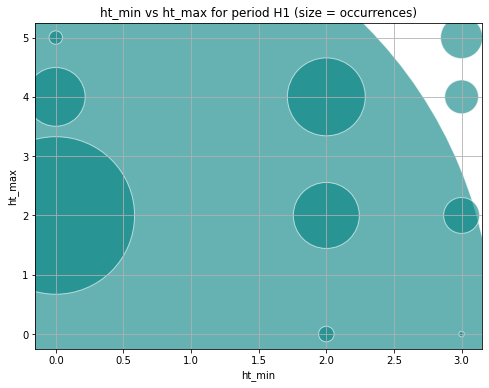

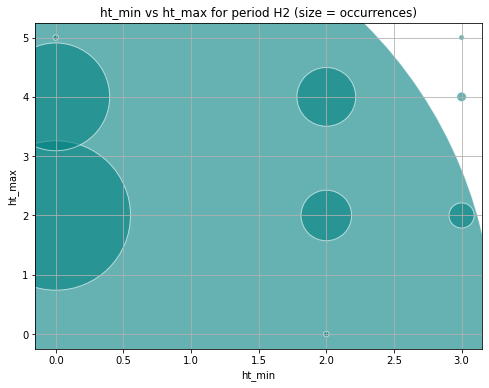

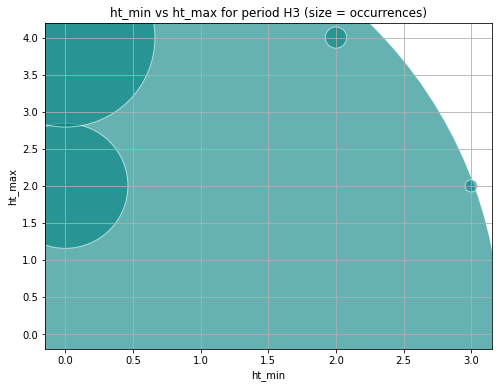

In [6]:
viz_h1 = VisualizeResults(df_results, periode='H1', show_table=False)
viz_h1.plot()

# Visualiser pour la période H2
viz_h2 = VisualizeResults(df_results, periode='H2', show_table=False)
viz_h2.plot()

# Visualiser pour la période H3
viz_h3 = VisualizeResults(df_results, periode='H3', show_table=False)
viz_h3.plot()


### Compute our scores

We get our **scores** for our **different portfolio** in function of our **scenario drias**.

In [13]:
# Load Data
url_localisation = r"data\ADMIN-EXPRESS_3-2__SHP_LAMB93_FXX_2025-02-17\ADMIN-EXPRESS\1_DONNEES_LIVRAISON_2025-02-00187\ADE_3-2_SHP_LAMB93_FXX-ED2025-02-17\COMMUNE.shp"

localisation = gpd.read_file(url_localisation)
localisation = localisation[['INSEE_COM', 'geometry']]
localisation["INSEE_COM"] = localisation["INSEE_COM"].astype("category")

# Call our class ScoreCreation
score_creator = ScoreCreation(
    localisation=localisation,
    current_year=2025,
    buffer_m=1000
)

# Comparing our Portfolio and scenarios
portfolios = ['Portefeuille_1.xlsx', 'Portefeuille_2.xlsx', 'Portefeuille_3.xlsx']
scenarios = ['RCP_2.6', 'RCP_4.5', 'RCP_8.5']

c = 0

for i, portfolio in enumerate(portfolios):
    print(f"\n### Portfolio {i} ###")

    for scenario in scenarios:
        url_output = f"prediction_data\{portfolio.split('.')[0]}_capital_risk_{scenario}.csv"

        results = score_creator.get_score(portfolio, scenario=scenario)
        results.to_csv(url_output, sep=";", index=False)

        if c % 3 == 0 :
            print(f"Encours total: {results['encours'].sum()}")
        c += 1

        print(f"\n### Results for scenario {scenario} ###")
        print(f"Risque financier total: {results['Risk_financier'].sum()}")



### Portfolio 0 ###
Encours total: 5340

### Results for scenario RCP_2.6 ###
Risque financier total: 3.447123643091367

### Results for scenario RCP_4.5 ###
Risque financier total: 60.955947319805205

### Results for scenario RCP_8.5 ###
Risque financier total: 5.871408030576761

### Portfolio 1 ###
Encours total: 4934

### Results for scenario RCP_2.6 ###
Risque financier total: 53.50375814378373

### Results for scenario RCP_4.5 ###
Risque financier total: 80.49266451140547

### Results for scenario RCP_8.5 ###
Risque financier total: 55.44610517071033

### Portfolio 2 ###
Encours total: 5112

### Results for scenario RCP_2.6 ###
Risque financier total: 69.50875920888721

### Results for scenario RCP_4.5 ###
Risque financier total: 120.30433324596603

### Results for scenario RCP_8.5 ###
Risque financier total: 60.144076741664676


### Descriptive statistic on our scenarios

In [8]:
variable_names = {
    'NORPAV': 'Précipitations journalières moyennes (mm)',
    'NORRR': 'Cumul de précipitation (mm)',
    'NORRR1MM': 'Nombre de jours de pluie (jours)',
    'NORPN20MM': 'Nombre de jours de fortes précipitations (jours)',
    'NORPFL90': 'Fraction des précipitations intenses (%)',
    'NORPXCDD': 'Période de sécheresse (jours)',
    'NORPINT': 'Précipitation moyenne les jours pluvieux (mm)',
    'NORPQ90': 'Précipitations intenses (Q90) (mm)',
    'NORPQ99': 'Précipitations extrêmes (Q99) (mm)',
    'NORRR99': 'Nombre de jours de précipitations extrêmes (jours)',
    'NORHUSAV': 'Humidité spécifique moyenne (g/kg)',
    'NORETPC': 'ETP cumulée (mm)',
    'dist_fleuve_km': 'Distance au fleuve (km)',
    'dist_riviere_km': 'Distance à la rivière (km)',
    'dist_cote_km': 'Distance à la côte (km)',
    'Flood_risk': 'Risque d’inondation',
    'ht_min': 'Hauteur minimale (m)',
    'ht_max': 'Hauteur maximale (m)',
    'alea': 'Aléa'
}


In [9]:
summary = score_creator.summarize_scenario(
    scenarios=['RCP_2.6', 'RCP_4.5', 'RCP_8.5'],
    folder='prediction_data',
    scaler_path='model/ht_scaler.pkl'
)

# Filtrer pour un scénario spécifique
#summary_rcp45 = summary[summary['scenario'] == 'RCP4.5']
summary_rcp45 = summary

summary_rcp45.sort_values(by=['variable', 'scenario'], inplace=True)

#summary_rcp45['variable'] = summary_rcp45['variable'].map(variable_names)

print("\nStatistiques pour RCP4.5:")
print(summary_rcp45)


Statistiques pour RCP4.5:
       variable      mean       std  min  max scenario periode   q1   q2   q3
0    Flood_risk  0.078351  0.426268  0.0  3.0  RCP_2.6      H1  0.0  0.0  0.0
19   Flood_risk  0.064098  0.387246  0.0  3.0  RCP_2.6      H2  0.0  0.0  0.0
38   Flood_risk  0.060869  0.377533  0.0  3.0  RCP_2.6      H3  0.0  0.0  0.0
57   Flood_risk  0.175036  0.621368  0.0  3.0  RCP_4.5      H1  0.0  0.0  0.0
76   Flood_risk  0.122332  0.528408  0.0  3.0  RCP_4.5      H2  0.0  0.0  0.0
..          ...       ...       ...  ...  ...      ...     ...  ...  ...  ...
77       ht_min  0.043462  0.313507  0.0  3.0  RCP_4.5      H2  0.0  0.0  0.0
96       ht_min  0.011135  0.164453  0.0  3.0  RCP_4.5      H3  0.0  0.0  0.0
115      ht_min  0.042052  0.313107  0.0  3.0  RCP_8.5      H1  0.0  0.0  0.0
134      ht_min  0.017704  0.194625  0.0  3.0  RCP_8.5      H2  0.0  0.0  0.0
153      ht_min  0.003786  0.101142  0.0  3.0  RCP_8.5      H3  0.0  0.0  0.0

[171 rows x 10 columns]


✓ Initialisé: 3 scénarios, 3 portfolios

RAPPORT COMPLET

CALCUL DES STATISTIQUES

--- RCP_2.6 ---
✓ Prediction: 242487 points (CRS: 2154)
✓ France: 4 variables
  Portfolio Portefeuille_1_capital_risk_RCP_2.6: 98 points (CRS: 2154)
  ✓ Portefeuille_1_capital_risk_RCP_2.6: 1782 matches, 4 variables
  Portfolio Portefeuille_2_capital_risk_RCP_4.5: 99 points (CRS: 2154)
  ✓ Portefeuille_2_capital_risk_RCP_4.5: 1674 matches, 4 variables
  Portfolio Portefeuille_3_capital_risk_RCP_8.5: 99 points (CRS: 2154)
  ✓ Portefeuille_3_capital_risk_RCP_8.5: 1674 matches, 4 variables

--- RCP_4.5 ---
✓ Prediction: 242487 points (CRS: 2154)
✓ France: 4 variables
  Portfolio Portefeuille_1_capital_risk_RCP_2.6: 98 points (CRS: 2154)
  ✓ Portefeuille_1_capital_risk_RCP_2.6: 1782 matches, 4 variables
  Portfolio Portefeuille_2_capital_risk_RCP_4.5: 99 points (CRS: 2154)
  ✓ Portefeuille_2_capital_risk_RCP_4.5: 1674 matches, 4 variables
  Portfolio Portefeuille_3_capital_risk_RCP_8.5: 99 points (CRS: 2154)

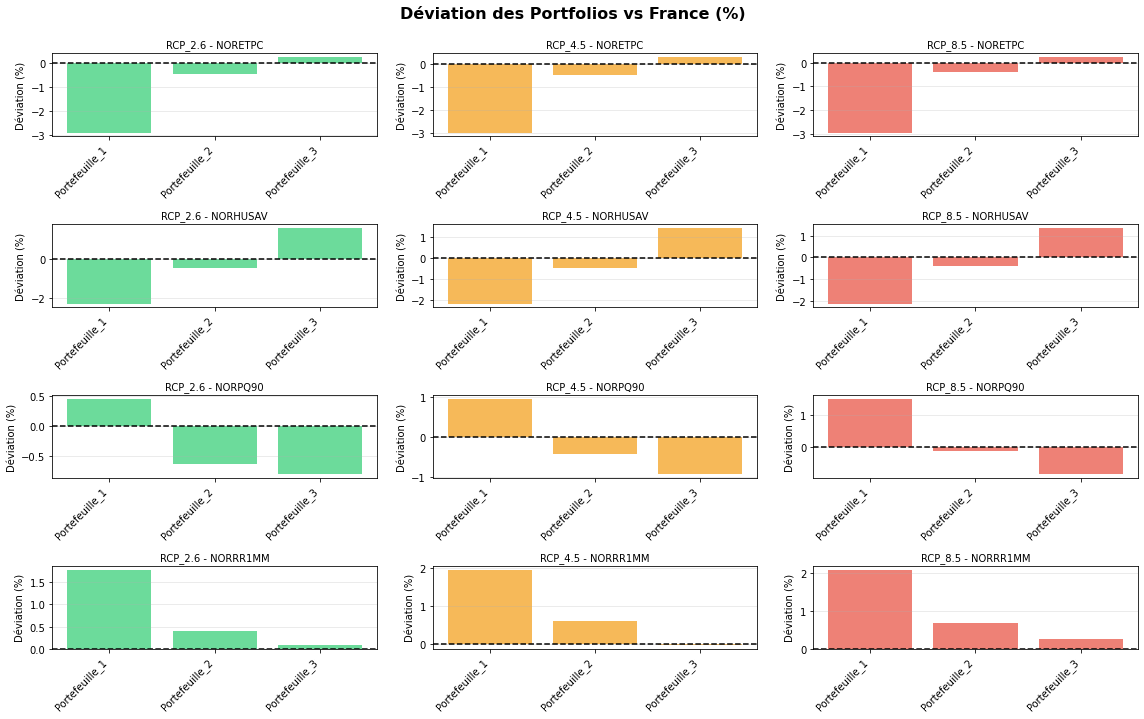

✓ Saved: visuals/deviation_portfolios_vs_france.png

✅ TERMINÉ: visuals


In [10]:
PCE = Portfolio_Context_Explained(
        scenario_files=['prediction_data/RCP_2.6_prediction.csv','prediction_data/RCP_4.5_prediction.csv','prediction_data/RCP_8.5_prediction.csv'],
        portfolio_files=['prediction_data/Portefeuille_1_capital_risk_RCP_2.6.csv','prediction_data/Portefeuille_2_capital_risk_RCP_4.5.csv','prediction_data/Portefeuille_3_capital_risk_RCP_8.5.csv'],
        buffer_m=1000,
        scaler_path='model/ht_scaler.pkl'
    )

results = PCE.generate_complete_report(output_folder='visuals')

